## Import modules

In [2]:
import sys
sys.path.insert(0,'..')
import pickle as pkl
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.data
import torch.optim as optim
import gym
import load_policy
import tensorflow as tf
import tf_util
%matplotlib inline

/Users/slakshay/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/slakshay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set up data class

In [3]:
class Data:
    def __init__(self, in_data, train_ratio=0.8, batch_size=100, only_final_results=True):
        
        assert (train_ratio >= 0 and train_ratio <= 1), "train_ratio must be in the range (0,1)"
        
        self.train_ratio = train_ratio
        self.val_ratio = 1 - train_ratio
        self.batch_size = batch_size
        if type(in_data) is str:
            data = pkl.load(open(in_data, "rb"))
            self.expert_stats = data['returns']
        else:
            data = in_data
            self.expert_stats = in_data['expert_stats']
        if not only_final_results:
            print('Train/val split: {}/{:.3f}'.format(self.train_ratio, self.val_ratio))
        self.X_train, self.X_val, self.y_train, self.y_val = self.split_data(data, only_final_results)
        
        self.input_dim = self.X_train.shape[1]
        self.output_dim = self.y_train.shape[1]
        
        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(self.X_train).float(), torch.from_numpy(self.y_train).float())
        val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(self.X_val).float(), torch.from_numpy(self.y_val).float())
        
        self.train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size)
        self.val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.X_val.shape[0])
        
    def split_data(self, data, only_final_results):
        '''Split dataset into training and validation sets'''
        obs = data['observations']
        actions = np.squeeze(data['actions'])
        
        X_train, X_val, y_train, y_val = \
         train_test_split(obs, actions, test_size=self.val_ratio, random_state=42)
        if not only_final_results:
            print('splitting and shuffling data:')
            print('X_train.shape', X_train.shape)
            print('X_val.shape', X_val.shape)
            print('y_train.shape', y_train.shape)
            print('y_val.shape', y_val.shape)
        return X_train, X_val, y_train, y_val
    
    def get_train_val(self):
        return self.train_data_loader, self.val_data_loader

## Create simple 2-layer network

In [4]:
class BCNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BCNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Create training and validation functions

In [5]:
def train(epochs, network, optimizer, loss_fn, train_loader, test_loader, testing=True, only_final_results=True):
    train_losses = []
    val_losses = []
    training_step = 0
    network.train()
    for epoch in range(1, epochs+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)
            loss = loss_fn(output, target)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

            training_step += 1

            if (not only_final_results) and ((training_step % 40 == 0) or (training_step == 1)) :
                print('Epoch {}; training step {} mse: {:.3f}'.format(epoch, training_step, loss.item()))
            
        if (testing):
            val_losses.append(validate(network, test_loader, loss_fn, only_final_results))   
            
    return train_losses, val_losses

In [6]:
def validate(network, test_loader, loss_fn, only_final_results):
    loss = 0
    steps = 0
    network.eval()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        output = network(data)
        loss += loss_fn(output, target).item()
        steps += 1
        
    avg_loss = loss / steps
    if not only_final_results:
        print('Test set mse: {:.3f}'.format(avg_loss))    
    return avg_loss

## Create dataset-aggregation-loop / test-routine

In [9]:
data = Data('../behavioral_cloning/expert_data/Hopper-v2_expert.pkl')
train_data_loader, val_data_loader = data.get_train_val()
only_final_results = True

expert_policy = load_policy.load_policy('../experts/Hopper-v2.pkl')
steps_list = []
returns_list = []

for i in range(200):
    all_obs = None
    all_actions = None
    print('agg iter:', i)
    bc_model = BCNet(data.input_dim, data.output_dim)
    optimizer = optim.Adam(bc_model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    train_losses, val_losses = train(10, bc_model, optimizer, loss_fn, train_data_loader, val_data_loader)

    with tf.Session():
        tf_util.initialize()

        env = gym.make('Hopper-v2')
        env.seed(42)
        max_steps = 1000
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = bc_model(torch.Tensor(obs)).detach().numpy()
            obs, r, done, _ = env.step(action)
            expert_action = expert_policy(obs[None,:])
            if all_obs is None:
                all_obs = obs
                all_actions = expert_action
            else:
                all_obs = np.vstack([all_obs, obs])
                all_actions = np.vstack([all_actions, expert_action])
            totalr += r
            steps += 1

            if  (not only_final_results) and (steps % 100 == 0): 
                print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                done = True
        print('Number of steps in this rollout: {}'.format(steps))
        steps_list.append(steps)
        print('total return: {:.3f}'.format(totalr))
        returns_list.append(totalr)
        
        all_obs = np.vstack([all_obs, data.X_train, data.X_val])
        all_actions = np.vstack([all_actions, data.y_train, data.y_val])
        in_data = {'observations' : all_obs, 
                   'actions' : all_actions, 
                   'expert_stats' : data.expert_stats}
        data = Data(in_data)
        train_data_loader, val_data_loader = data.get_train_val()

agg iter: 0
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


/Users/slakshay/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Number of steps in this rollout: 122
total return: 241.938
agg iter: 1
Number of steps in this rollout: 83
total return: 169.604
agg iter: 2
Number of steps in this rollout: 145
total return: 366.368
agg iter: 3
Number of steps in this rollout: 92
total return: 219.338
agg iter: 4
Number of steps in this rollout: 48
total return: 81.754
agg iter: 5
Number of steps in this rollout: 209
total return: 659.932
agg iter: 6
Number of steps in this rollout: 86
total return: 183.647
agg iter: 7
Number of steps in this rollout: 232
total return: 741.311
agg iter: 8
Number of steps in this rollout: 160
total return: 462.317
agg iter: 9
Number of steps in this rollout: 161
total return: 483.927
agg iter: 10
Number of steps in this rollout: 157
total return: 455.195
agg iter: 11
Number of steps in this rollout: 156
total return: 470.066
agg iter: 12
Number of steps in this rollout: 308
total return: 1088.846
agg iter: 13
Number of steps in this rollout: 135
total return: 319.639
agg iter: 14
Numbe

Number of steps in this rollout: 244
total return: 856.801
agg iter: 115
Number of steps in this rollout: 380
total return: 1412.039
agg iter: 116
Number of steps in this rollout: 575
total return: 2163.585
agg iter: 117
Number of steps in this rollout: 287
total return: 1007.400
agg iter: 118
Number of steps in this rollout: 270
total return: 914.455
agg iter: 119
Number of steps in this rollout: 312
total return: 1129.877
agg iter: 120
Number of steps in this rollout: 271
total return: 930.517
agg iter: 121
Number of steps in this rollout: 312
total return: 1123.240
agg iter: 122
Number of steps in this rollout: 351
total return: 1298.520
agg iter: 123
Number of steps in this rollout: 298
total return: 1064.542
agg iter: 124
Number of steps in this rollout: 319
total return: 1137.251
agg iter: 125
Number of steps in this rollout: 615
total return: 1912.164
agg iter: 126
Number of steps in this rollout: 328
total return: 1184.168
agg iter: 127
Number of steps in this rollout: 285
tota

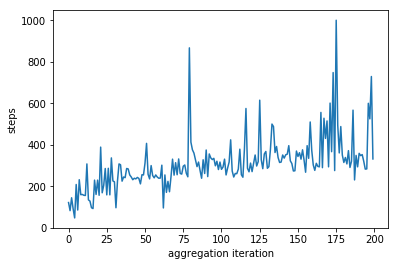

max steps: 1000; in iteration 175


In [10]:
plt.plot(np.asarray(steps_list))
plt.ylabel('steps')
plt.xlabel('aggregation iteration')
plt.show()
print('max steps: {}; in iteration {}'.format(np.max(np.asarray(steps_list)), np.argmax(np.asarray(steps_list))))

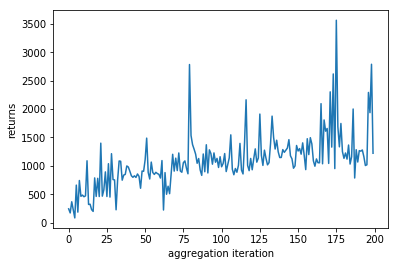

max return: 3565.7369, in iteration 175
mean of returns: 1080.2820
std of returns: 470.5878


In [11]:
plt.plot(np.asarray(returns_list))
plt.ylabel('returns')
plt.xlabel('aggregation iteration')
plt.show()
print('max return: {:.4f}, in iteration {}'.format(np.max(np.asarray(returns_list)), np.argmax(np.asarray(returns_list))))
print('mean of returns: {:.4f}'.format(np.mean(np.asarray(returns_list))))
print('std of returns: {:.4f}'.format(np.std(np.asarray(returns_list))))

##### Note that since the maximum number of steps allowed is 1000, it is possible that there are two iterations with 1000 steps but different returns; in this situation, the same iteration won't be printed above for `max steps` and `max return`. However, it is expected that the return value be similar.

In [12]:
print('mean of returns of expert policy: {:.4f}'.format(data.expert_stats['mean']))

mean of returns of expert policy: 3779.3959


##### Since the `max return` of DAgger is comparable to the average return of the expert policy, it can be seen that with sufficient data aggregation, DAgger can train a policy that has performance comparable to the expert. 